We implement a simple *neuronal network* (NN). That is, given an input vector $X$, the NN is defined from a mathematical viewpoint as the function $f$ which has the form
$$
f(X) = \mathcal{A}_N \circ \mathcal{A}_{N-1} \circ \dots \circ \mathcal{A}_2 \circ \mathcal{A}_1(X).
$$
Here, $\mathcal{A}_i$ is defined as the composition of an affine function $Z_i(X) = W_i(X) + b_i$ (where $W_i$ is a matrix and $b_i$ an offset vector) with an activation function $\sigma_i$, that is $\mathcal{A}_i = \sigma_i(Z_i)$. Typically, $\sigma_i$ is either a *sigmoid function* 
$$
\sigma_i(x_1, \dots, x_n) = \left(\frac{1}{1 - e^{-x_1}}, \dots, \frac{1}{1 - e^{-x_N}}\right)
$$
or a *ReLu function*
$$
\sigma_i(x_1, \dots, x_n) = \left(\max(0, x_1), \dots, \max(0, x_N)\right).
$$

In [1]:
import numpy as np

We start by defining the architecture of our NN.
The function *init_layers* instantiate the weights of $W_i$ and $b_i$ randomly.

In [2]:
NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 10, "activation": "relu"},
    {"input_dim": 10, "output_dim": 20, "activation": "relu"},
    {"input_dim": 20, "output_dim": 20, "activation": "relu"},
    {"input_dim": 20, "output_dim": 10, "activation": "relu"},
    {"input_dim": 10, "output_dim": 1, "activation": "sigmoid"},
]

def init_layers(nn_architecture):
    params_values = {}
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1

        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]

        params_values['W' + str(layer_idx)] = np.random.rand(layer_output_size,layer_input_size)
        params_values['b' + str(layer_idx)] = np.random.rand(layer_input_size,1)
        
    return params_values

In [21]:
def sigmoid(Z):
    return(1/(1+np.exp(-Z)))

def relu(Z):
    return((Z>0)*Z)
    #return(np.maximum(0,Z))

def sigmoid_backward(dA, Z):
    return((sigmoid(Z)*(1-sigmoid(Z))).dot(dA))

def relu_backward(dA, Z):
    return((Z>0).dot(dA))


We decompose the forward graph into small bits of computations. The function *single_layer_forward_propagation* takes $A_{i-1} = \mathcal{A}_{i-1} \circ \dots \circ \mathcal{A}_1(X)$, the current weights $W_i$ and $b_i$, the type of activation function, and compute $\mathcal{A}_i = \sigma_i( Z_i)$ where $Z_i = W_i A_{i-1} + b_i$.

In [19]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    Z_curr = np.dot(W_curr,A_prev)+b_curr

    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid

    return activation_func(Z_curr), Z_curr

We then perform the full forward propagation of the NN. We keep in a *memory* dictionnary the values of the NN at each nodes, that is both $Z_i = W_i A_{i-1} + b_i$ and $A_i = \sigma_i(Z_i)$.

In [5]:
def full_forward_propagation(X, params_values, nn_architecture):
    memory = {}
    A_curr = X
  
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        A_prev = A_curr
        
        activ_function_curr = layer["activation"]
        W_curr = params_values["W" + str(layer_idx)]
        b_curr = params_values["b" + str(layer_idx)]
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activation=activ_function_curr)
       
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
    return A_curr, memory

We use cross-entropy as a measurement of our NN:
$$
L(\hat{Y}, Y) = \frac 1 m\sum_{i = 1}^m \ell(\hat{Y}_i, Y_i)
$$
where
$$
\ell(\hat{y}, y) = - y \ln(\hat{y})- (1-y)\log(1 - \hat{y}).
$$

In [6]:
def get_cost_value(Y_hat, Y):
    m = Y_hat.shape[1]
    cost = -(1/m)*(np.dot(Y,np.log(Y_hat).T)+np.dot(1-Y,np.log(1-Y_hat).T))
    return np.squeeze(cost)

In [7]:
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

We now consider the backward propagation. Once again, we decompose the propagation into bits of propagation units, using *single_layer_backward_propagation*. Given the current $\delta A_i$, it computes $\delta A_{i-1}$, as well as $\delta W_{i-1}$ and $\delta b_i$.

In [8]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    # number of examples
    m = A_prev.shape[1]
    
    # selection of activation function
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    
    # calculation of the activation function derivative
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    dW_curr = np.dot(dZ_curr, A_prev.T)/m
    db_curr = np.sum(dZ_curr)/m
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

Putting everything together, we can compute the full backward propagation. It keeps in a *grads_values* dictionnary all the gradients $\partial L(X)/ \partial W_i$ and $\partial L(X)/\partial b_i$. 

In [9]:
def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    m = Y.shape[1]

    dA_prev = -(np.divide(Y,Y_hat)-np.divide(1-Y,1-Y_hat))
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev + 1
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr =  single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation=activ_function_curr)
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

The gradient descent is then implement by updating each weights $W_i$ and $b_i$:

In [10]:
def update(params_values, grads_values, nn_architecture, learning_rate):

    # iteration over network layers
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values;

Finally, let us implement the training.

In [17]:
def train(X, Y, nn_architecture, epochs, learning_rate, verbose=True, callback=None):
    params_values = init_layers(nn_architecture)
    cost_history = []
    accuracy_history = []
    
    # performing calculations for subsequent iterations
    for i in range(epochs):
        Y_hat, cache = full_forward_propagation(X, params_values, nn_architecture)
        
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        
        grads_values = full_backward_propagation(Y_hat, Y, cache, params_values, nn_architecture)
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
        if(i % 50 == 0):
            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            if(callback is not None):
                callback(i, params_values)
            
    return params_values

In [12]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

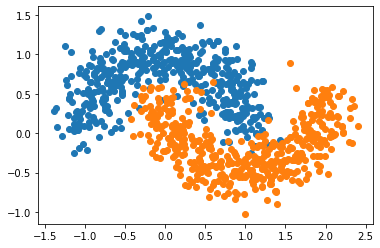

In [13]:
N_SAMPLES = 1000
TEST_SIZE = 0.1

X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

Z1 = X_train[y_train == 0]; Z2 = X_train[y_train == 1]
plt.scatter(Z1[:,0], Z1[:,1])
plt.scatter(Z2[:,0], Z2[:,1])

In [23]:
# Training
params_values = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 10000, 0.01)
# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)
# Accuracy achieved on the test set
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
print("Test set accuracy: {:.2f}".format(acc_test))

#ABANDON : probleme de taille

ValueError: ignored